# Data source

In [1]:
# Data source:
# Open Power System Data – Time Series dataset
# URL: https://data.open-power-system-data.org/time_series/

In [2]:
# pip install pmdarima

In [3]:
import joblib
import calendar
import random
import pandas as pd
import numpy as np
import pmdarima as pm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')  # Use a more professional chart style
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data overview

## 1. Load data 

In [4]:
data = pd.read_csv("time_series_15min_singleindex.csv")

In [5]:
data.head(3)

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,DE_load_actual_entsoe_transparency,...,HU_solar_generation_actual,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-31T23:15:00Z,2015-01-01T00:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-31T23:30:00Z,2015-01-01T00:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.columns

Index(['utc_timestamp', 'cet_cest_timestamp',
       'AT_load_actual_entsoe_transparency',
       'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead',
       'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual',
       'BE_load_actual_entsoe_transparency',
       'BE_load_forecast_entsoe_transparency',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile',
       'DE_50hertz_load_actual_entsoe_transparency',
       'DE_50hertz_load_forecast_entsoe_transparency',
       'DE_50hertz_solar_generation_actual',
       'DE_50hertz_wind_generation_actual',
       'DE_50hertz_wind_

In [7]:
# Use only German solar power generation data
solar_df = data[["utc_timestamp", "DE_solar_generation_actual"]].copy()

## 2. Convert timestamp and set as index

In [8]:
solar_df["utc_timestamp"] = pd.to_datetime(solar_df["utc_timestamp"])
solar_df.set_index("utc_timestamp", inplace=True)
solar_df.index.name = "timestamp"  # Give the index a clear name

In [9]:
solar_df.head(3)

,DE_solar_generation_actual
timestamp,
2014-12-31 23:00:00+00:00,NaN
2014-12-31 23:15:00+00:00,NaN
2014-12-31 23:30:00+00:00,NaN


## 3. Print key overview information

In [10]:
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Original Data Shape: {solar_df.shape}")
print(f"Time Range: {solar_df.index.min()} to {solar_df.index.max()}")
print(f"Inferred Frequency: {solar_df.index.inferred_freq or 'Possibly Irregular'}")
print(f"Total Days: {(solar_df.index.max() - solar_df.index.min()).days} days")
expected_points = int((solar_df.index.max() - solar_df.index.min()) / pd.Timedelta(minutes=15)) + 1
print(f"Expected Data Points (15-min interval): {expected_points}")
print(f"Actual Data Points: {len(solar_df)}")
print(f"Data Completeness: {len(solar_df) / ((solar_df.index.max() - solar_df.index.min()).days * 24 * 4):.2%}")

DATASET OVERVIEW
Original Data Shape: (201604, 1)
Time Range: 2014-12-31 23:00:00+00:00 to 2020-09-30 23:45:00+00:00
Inferred Frequency: 15min
Total Days: 2100 days
Expected Data Points (15-min interval): 201604
Actual Data Points: 201604
Data Completeness: 100.00%


In [11]:
solar_df.info

<bound method DataFrame.info of                            DE_solar_generation_actual
timestamp                                            
2014-12-31 23:00:00+00:00                         NaN
2014-12-31 23:15:00+00:00                         NaN
2014-12-31 23:30:00+00:00                         NaN
2014-12-31 23:45:00+00:00                         NaN
2015-01-01 00:00:00+00:00                         NaN
...                                               ...
2020-09-30 22:45:00+00:00                        0.05
2020-09-30 23:00:00+00:00                        0.02
2020-09-30 23:15:00+00:00                         NaN
2020-09-30 23:30:00+00:00                         NaN
2020-09-30 23:45:00+00:00                         NaN

[201604 rows x 1 columns]>

In [12]:
print("\n" + "=" * 60)
print("DATA INFO:")
print("=" * 60)
print(solar_df.info())

print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS:")
print("=" * 60)
print(solar_df.describe())


DATA INFO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201604 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:45:00+00:00
Data columns (total 1 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   DE_solar_generation_actual  201184 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB
None

DESCRIPTIVE STATISTICS:
       DE_solar_generation_actual
count               201184.000000
mean                  4566.134215
std                   6964.591224
min                      0.000000
25%                      0.000000
50%                    106.400000
75%                   7377.905000
max                  33193.770000


# Handle missing value

## 1. Record the original missing data situation

In [13]:
original_missing = solar_df["DE_solar_generation_actual"].isna().sum()
print(f"Original Missing Values Count: {original_missing} ({original_missing/len(solar_df):.2%})")

Original Missing Values Count: 420 (0.21%)


In [14]:
missing = solar_df["DE_solar_generation_actual"].isna()
missing_dates = solar_df.index[missing]

daily_missing = missing.groupby(missing.index.date).sum()
missing_days = daily_missing[daily_missing > 0]
print(missing_days)

2014-12-31     4
2015-01-01    29
2015-02-28    96
2016-05-31    12
2016-06-01    84
2016-10-27     8
2016-10-28    88
2016-12-08     4
2016-12-09    92
2020-09-30     3
Name: DE_solar_generation_actual, dtype: int64


## 2. Fill missing values

In [15]:
# Step 1: Define small gaps threshold
small_gap_threshold = 12  # number of missing time steps considered as a 'small gap'

# Step 2: Identify days with small gaps
# 'daily_missing' contains the number of missing time steps per day
small_gap_days = daily_missing[daily_missing <= small_gap_threshold].index

# Step 3: Forward-fill missing values for small gaps
# For each day with a small number of missing points, fill missing values using previous valid value
for day in small_gap_days:
    mask = solar_df.index.date == day
    solar_df.loc[mask, "DE_solar_generation_actual"] = solar_df.loc[mask, "DE_solar_generation_actual"].ffill()

# Step 4: Forward-fill remaining missing values
solar_df["DE_solar_generation_actual"] = solar_df["DE_solar_generation_actual"].ffill()

# Step 5: Backward-fill any remaining missing values
# This handles missing values at the start of the series (e.g., the first record)
solar_df["DE_solar_generation_actual"] = solar_df["DE_solar_generation_actual"].bfill()

In [16]:
solar_df.isna().sum()

DE_solar_generation_actual    0
dtype: int64

# Identify trends and patterns

## 1. Overall Solar Generation Trends (2014-2020)

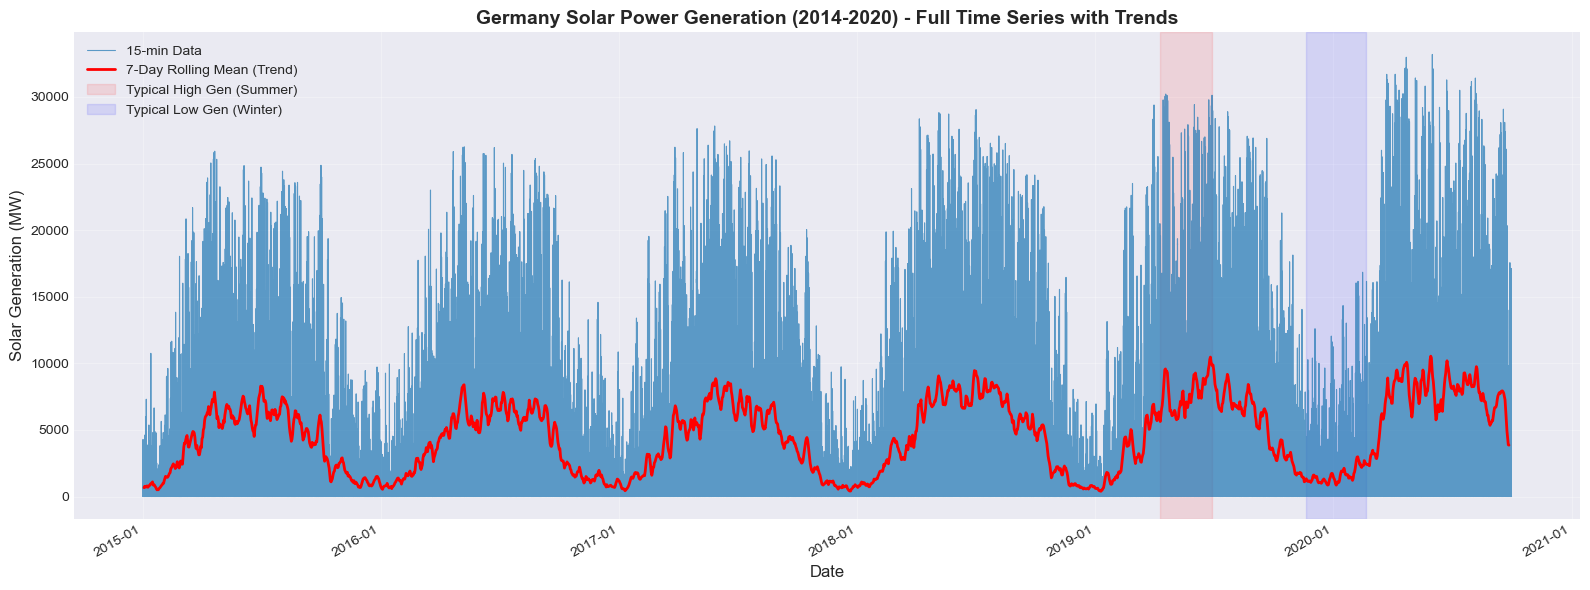

In [17]:
plt.figure(figsize=(16, 6))

# Plot the full time series
plt.plot(solar_df.index, solar_df["DE_solar_generation_actual"], 
         color='tab:blue', alpha=0.7, linewidth=0.8, label='15-min Data')

# Add a rolling average to highlight the trend (7-day window, daily resampled for efficiency)
# First, resample to daily to speed up the rolling calculation if needed
daily_series = solar_df["DE_solar_generation_actual"].resample('D').mean()
rolling_avg = daily_series.rolling(window=7, center=True).mean()

# Plot the rolling average (trend line)
plt.plot(rolling_avg.index, rolling_avg.values, 
         color='red', linewidth=2, label='7-Day Rolling Mean (Trend)')

# Highlight key periods for discussion (e.g., winter peaks, summer troughs)
# Add shaded regions for typical high/low generation seasons
plt.axvspan(pd.Timestamp('2019-04-10'), pd.Timestamp('2019-06-30'), 
            alpha=0.1, color='red', label='Typical High Gen (Summer)')
plt.axvspan(pd.Timestamp('2019-11-20'), pd.Timestamp('2020-02-20'), 
            alpha=0.1, color='blue', label='Typical Low Gen (Winter)')

plt.xlabel("Date", fontsize=12)
plt.ylabel("Solar Generation (MW)", fontsize=12)
plt.title("Germany Solar Power Generation (2014-2020) - Full Time Series with Trends", 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Improve x-axis ticks for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()  # Auto-format dates

plt.tight_layout()
plt.show()

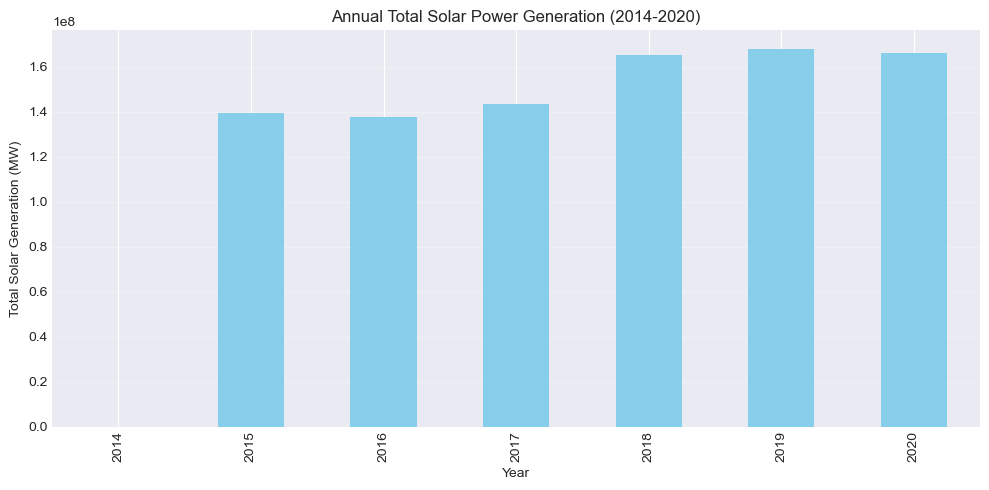

In [18]:
solar_df['year'] = solar_df.index.year
solar_df['month'] = solar_df.index.month
annual_total = solar_df.groupby('year')['DE_solar_generation_actual'].sum()

plt.figure(figsize=(10, 5))
annual_total.plot(kind='bar', color='skyblue')
plt.xlabel("Year")
plt.ylabel("Total Solar Generation (MW)")
plt.title("Annual Total Solar Power Generation (2014-2020)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# ============================================================================
# DATA INSIGHTS FROM GLOBAL VIEW
# ============================================================================
print("=" * 70)
print("KEY INSIGHTS FROM FULL TIME SERIES ANALYSIS")
print("=" * 70)

# 1. Calculate basic statistics
print("\n1. OVERALL STATISTICS:")
print(f"   • Total Period: {solar_df.index.min().date()} to {solar_df.index.max().date()}")
print(f"   • Average Generation: {solar_df["DE_solar_generation_actual"].mean():.0f} MW")
print(f"   • Maximum Generation: {solar_df["DE_solar_generation_actual"].max():.0f} MW")
print(f"   • Minimum Generation: {solar_df["DE_solar_generation_actual"].min():.0f} MW")

# 2. Identify seasonal pattern
print("\n2. SEASONAL PATTERN IDENTIFICATION:")
# Calculate monthly averages across all years
solar_df['month'] = solar_df.index.month
monthly_avg = solar_df.groupby('month')["DE_solar_generation_actual"].mean()

# Find top 3 and bottom 3 months
top_months = monthly_avg.nlargest(3)
bottom_months = monthly_avg.nsmallest(3)

print(f"   • Highest Generation Months: {', '.join([f'{i} ({v:.0f} MW)' for i, v in top_months.items()])}")
print(f"   • Lowest Generation Months: {', '.join([f'{i} ({v:.0f} MW)' for i, v in bottom_months.items()])}")

# 3. Check for growth trend
print("\n3. YEAR-OVER-YEAR TREND:")
annual_totals = solar_df["DE_solar_generation_actual"].resample('YE').sum()
growth_rates = annual_totals.pct_change() * 100

for year, growth in zip(annual_totals.index[1:], growth_rates.dropna()):
    print(f"   • {year.year}: {growth:+.1f}% change from previous year")

print("\n" + "=" * 70)

KEY INSIGHTS FROM FULL TIME SERIES ANALYSIS

1. OVERALL STATISTICS:
   • Total Period: 2014-12-31 to 2020-09-30
   • Average Generation: 4557 MW
   • Maximum Generation: 33194 MW
   • Minimum Generation: 0 MW

2. SEASONAL PATTERN IDENTIFICATION:
   • Highest Generation Months: 6 (7425 MW), 7 (7378 MW), 5 (7034 MW)
   • Lowest Generation Months: 12 (961 MW), 1 (1027 MW), 11 (1446 MW)

3. YEAR-OVER-YEAR TREND:
   • 2015: +245394367.0% change from previous year
   • 2016: -1.2% change from previous year
   • 2017: +4.4% change from previous year
   • 2018: +14.9% change from previous year
   • 2019: +1.7% change from previous year
   • 2020: -1.1% change from previous year



## 2. Monthly Distribution of Solar Generation

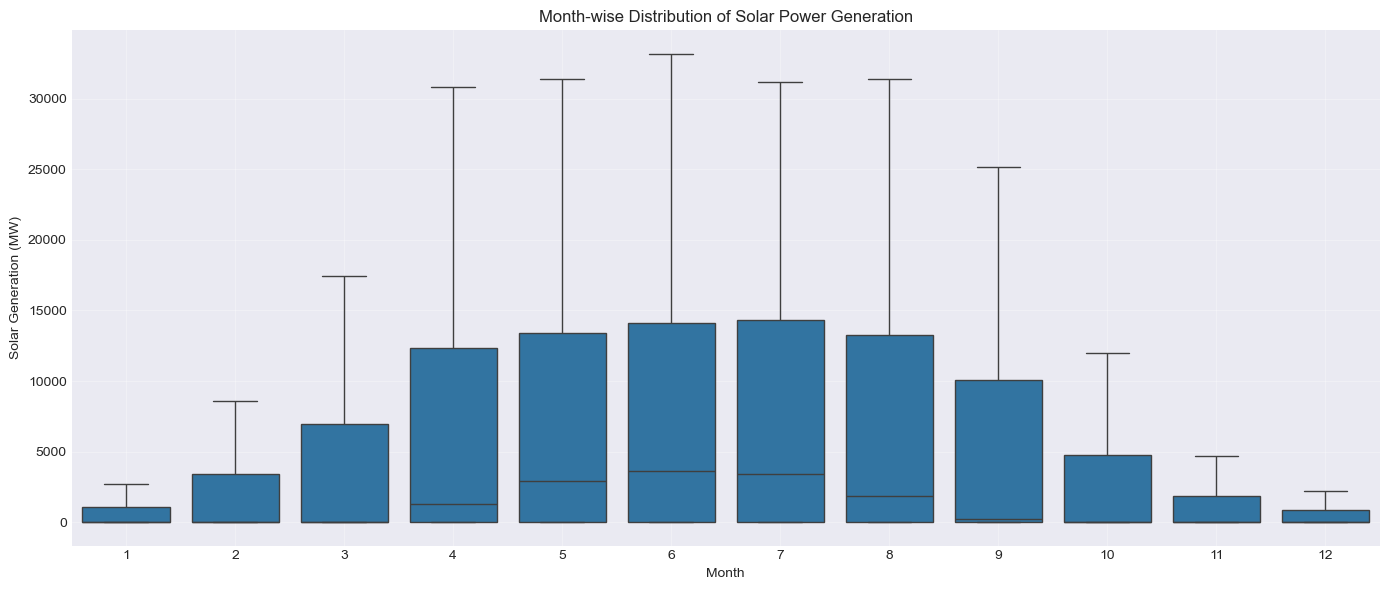

In [20]:
plt.figure(figsize=(14, 6))

# Boxplot 
sns.boxplot(x='month', y='DE_solar_generation_actual', data=solar_df, showfliers=False)
plt.xlabel("Month")
plt.ylabel("Solar Generation (MW)")
plt.title("Month-wise Distribution of Solar Power Generation")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Inter-annual and Seasonal Patterns

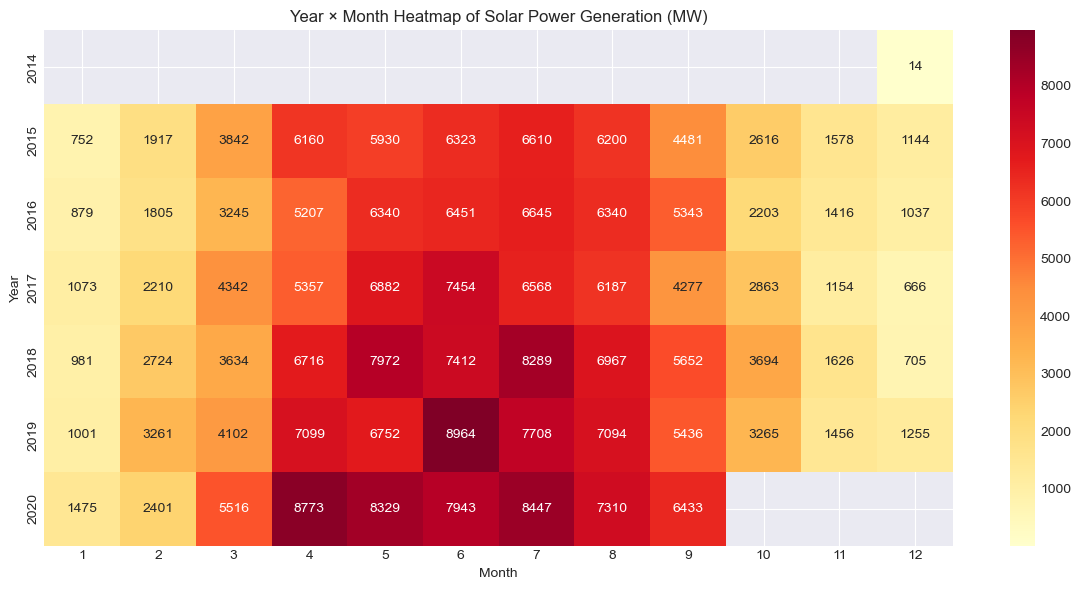

In [21]:
monthly_avg = solar_df.groupby(['year', 'month'])['DE_solar_generation_actual'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_avg, annot=True, fmt=".0f", cmap="YlOrRd")  
plt.xlabel("Month")
plt.ylabel("Year")
plt.title("Year × Month Heatmap of Solar Power Generation (MW)")
plt.tight_layout()
plt.show()

## 4. Weekly trend detection

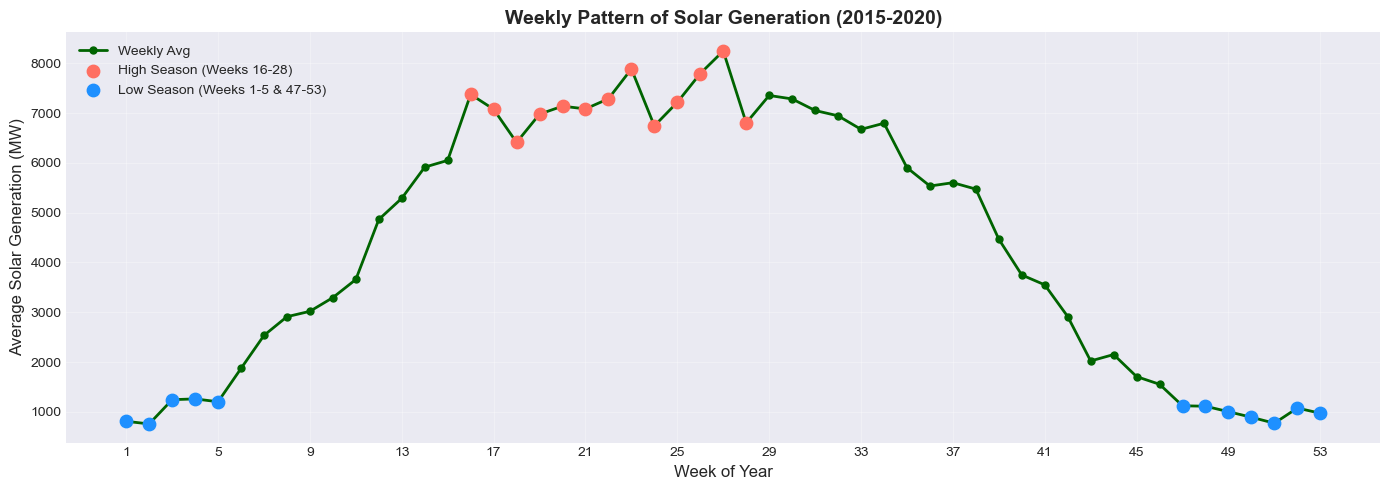

In [22]:
solar_df['week'] = solar_df.index.isocalendar().week
solar_df['weekday'] = solar_df.index.dayofweek
weekly_avg = solar_df.groupby('week')["DE_solar_generation_actual"].mean()

plt.figure(figsize=(14, 5))
plt.plot(weekly_avg.index, weekly_avg.values, color='darkgreen', linewidth=2, marker='o', markersize=5, label='Weekly Avg')

# High Season (Weeks 16-28)
plt.scatter(range(16, 29), weekly_avg.loc[16:28], color='#FF6F61', s=80, zorder=5, label='High Season (Weeks 16-28)')

# Low Season (Weeks 1-5 & 47-53)
low_weeks = list(range(1, 6)) + list(range(47, 54))
plt.scatter(low_weeks, weekly_avg.loc[low_weeks], color='#1E90FF', s=80, zorder=5, label='Low Season (Weeks 1-5 & 47-53)')

plt.xticks(range(1, 54, 4))
plt.xlabel("Week of Year", fontsize=12)
plt.ylabel("Average Solar Generation (MW)", fontsize=12)
plt.title("Weekly Pattern of Solar Generation (2015-2020)", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [23]:
print("\n" + "=" * 60)
print("WEEKLY PATTERN VALIDATION")
print("=" * 60)
print(f"• Weeks 1-5 Avg: {weekly_avg.loc[1:5].mean():.0f} MW")
print(f"• Week 2 Value: {weekly_avg.loc[2]:.0f} MW (Lowest)")
print(f"• Weeks 16-28 Avg: {weekly_avg.loc[16:28].mean():.0f} MW")


WEEKLY PATTERN VALIDATION
• Weeks 1-5 Avg: 1054 MW
• Week 2 Value: 757 MW (Lowest)
• Weeks 16-28 Avg: 7233 MW


## 5. Hourly trend detection

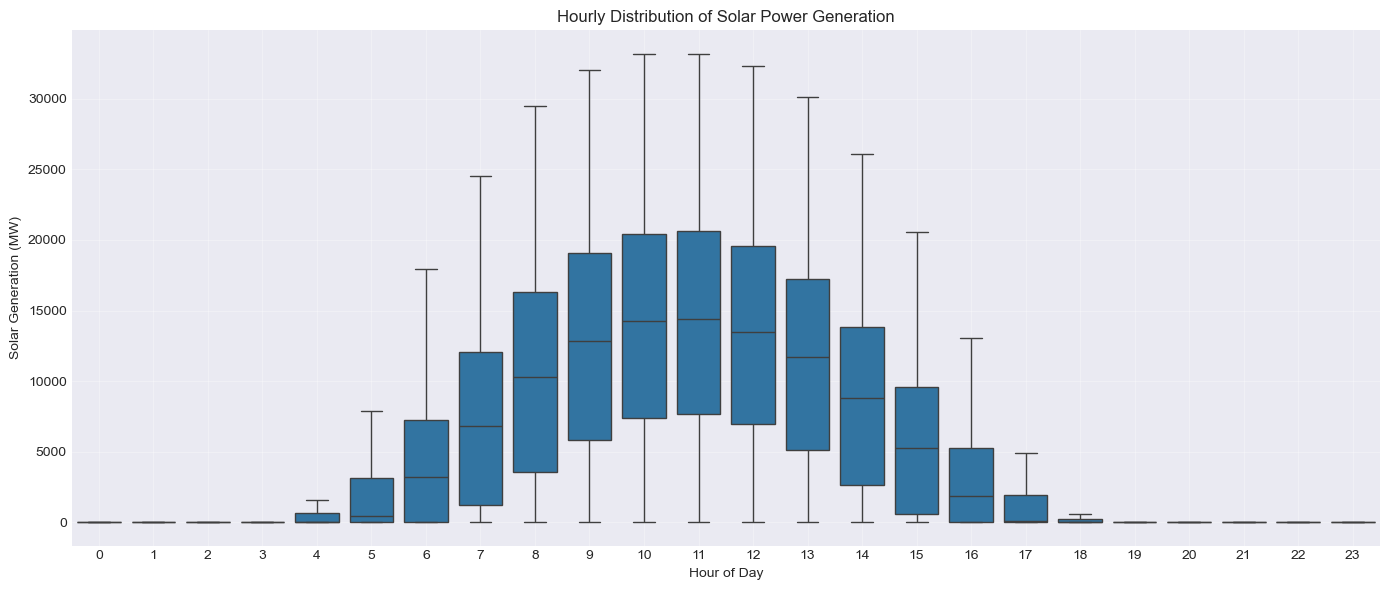

In [24]:
solar_df['hour'] = solar_df.index.hour

plt.figure(figsize=(14,6))
sns.boxplot(x='hour', y='DE_solar_generation_actual', data=solar_df, showfliers=False)
plt.xlabel("Hour of Day")
plt.ylabel("Solar Generation (MW)")
plt.title("Hourly Distribution of Solar Power Generation")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Time series decomposition

## 1. Global view

<Figure size 1400x500 with 0 Axes>

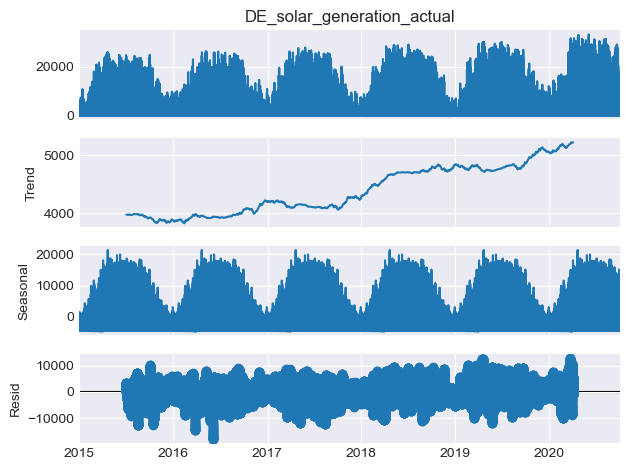

In [25]:
series = solar_df["DE_solar_generation_actual"]

# Seasonal decomposition
# model='additive': assume additive relationship between trend, seasonal, and residual
# period=96*365: there are 96 data points per day (15-minute intervals), 
# so 96*365 corresponds to a one-year seasonal cycle
result = seasonal_decompose(series, model='additive', period=96*365)  

plt.figure(figsize=(14,5))
result.plot()
plt.show()

## 2. Daily and weekly profile

In [26]:
solar_df.head()

,DE_solar_generation_actual,year,month,week,weekday,hour
timestamp,,,,,,
2014-12-31 23:00:00+00:00,14.18,2014,12,1,2,23
2014-12-31 23:15:00+00:00,14.18,2014,12,1,2,23
2014-12-31 23:30:00+00:00,14.18,2014,12,1,2,23
2014-12-31 23:45:00+00:00,14.18,2014,12,1,2,23
2015-01-01 00:00:00+00:00,14.18,2015,1,1,3,0


In [27]:
print("=" * 70)
print("TIME SERIES DECOMPOSITION STRATEGY")
print("=" * 70)
print("Step 1: Analyze LONG-TERM trends and ANNUAL seasonality using DAILY data")
print("Step 2: Analyze INTRADAY patterns using SHORT periods")
print("=" * 70)

TIME SERIES DECOMPOSITION STRATEGY
Step 1: Analyze LONG-TERM trends and ANNUAL seasonality using DAILY data
Step 2: Analyze INTRADAY patterns using SHORT periods


In [28]:
# ------------------------------------------------------------
# STEP 1: LONG-TERM DECOMPOSITION (Daily Data)
# ------------------------------------------------------------
print("\n1. RESAMPLING to DAILY frequency for trend/seasonality analysis...")
daily_series = solar_df["DE_solar_generation_actual"].resample('D').mean()

print(f"   • Original shape (15-min): {solar_df.shape}")
print(f"   • Resampled shape (daily): {daily_series.shape}")
print(f"   • Period for decomposition: 365 days (annual cycle)")

# Perform decomposition on daily data
print("\n2. Performing seasonal decomposition ")
result_daily = seasonal_decompose(daily_series, model='additive', period=365)


1. RESAMPLING to DAILY frequency for trend/seasonality analysis...
   • Original shape (15-min): (201604, 6)
   • Resampled shape (daily): (2101,)
   • Period for decomposition: 365 days (annual cycle)

2. Performing seasonal decomposition 


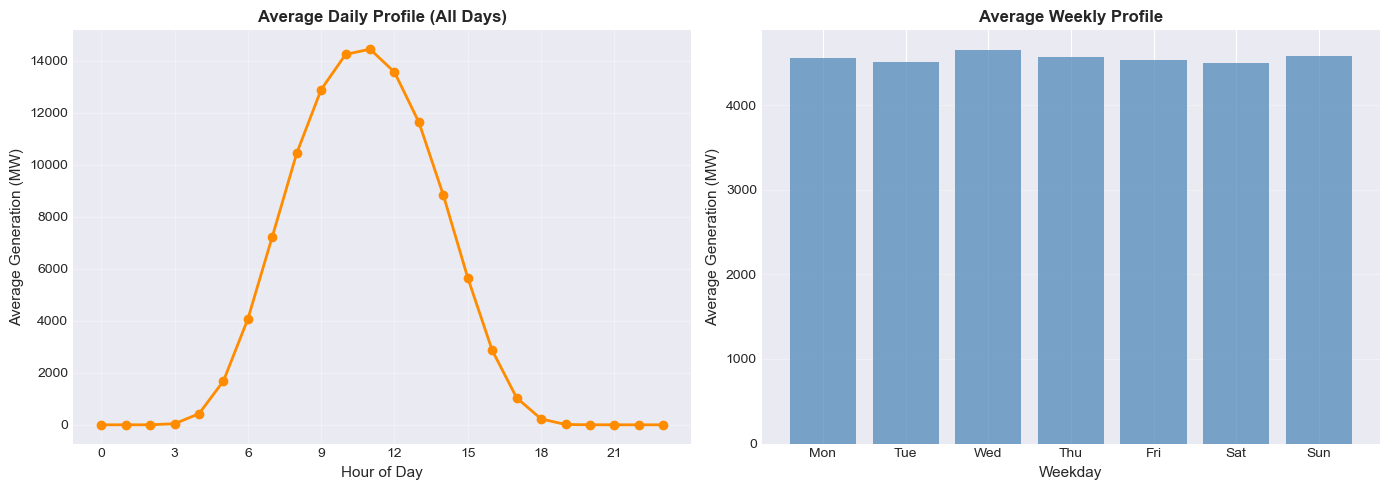

In [29]:
# Analyze typical daily profile (average generation by hour)
hourly_profile = solar_df.groupby('hour')['DE_solar_generation_actual'].mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Daily profile
ax[0].plot(hourly_profile.index, hourly_profile.values, 
           marker='o', color='darkorange', linewidth=2)
ax[0].set_xlabel('Hour of Day', fontsize=11)
ax[0].set_ylabel('Average Generation (MW)', fontsize=11)
ax[0].set_title('Average Daily Profile (All Days)', fontsize=12, fontweight='bold')
ax[0].grid(True, alpha=0.3)
ax[0].set_xticks(range(0, 24, 3))

# Weekly profile (by weekday)
weekday_profile = solar_df.groupby('weekday')['DE_solar_generation_actual'].mean()

weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax[1].bar(range(7), weekday_profile.values, color='steelblue', alpha=0.7)
ax[1].set_xlabel('Weekday', fontsize=11)
ax[1].set_ylabel('Average Generation (MW)', fontsize=11)
ax[1].set_title('Average Weekly Profile', fontsize=12, fontweight='bold')
ax[1].grid(True, alpha=0.3, axis='y')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(weekday_names)

plt.tight_layout()
plt.show()

In [30]:
print("\n" + "=" * 70)
print("DECOMPOSITION FINDINGS SUMMARY")
print("=" * 70)

# Check residual statistics (should be close to white noise)
resid_mean = result_daily.resid.mean()
resid_std = result_daily.resid.std()

print(f"\n1. RESIDUAL ANALYSIS:")
print(f"   • Mean of residuals: {resid_mean:.2f} MW (should be close to zero)")
print(f"   • Std of residuals: {resid_std:.2f} MW")
print(f"   • 95% of residuals lie within: "
      f"[{resid_mean - 2*resid_std:.0f}, {resid_mean + 2*resid_std:.0f}] MW")

print(f"\n2. SEASONAL STRENGTH:")
seasonal_amplitude = result_daily.seasonal.max() - result_daily.seasonal.min()
print(f"   • Annual seasonal amplitude: {seasonal_amplitude:.0f} MW")
print(f"   • Relative magnitude: "
      f"{(seasonal_amplitude / daily_series.mean() * 100):.1f}% of mean generation")

print(f"\n3. MODELING IMPLICATIONS:")
print(f"   • Strong ANNUAL seasonality driven by solar irradiation")
print(f"   • No pronounced WEEKLY pattern across weekdays")
print(f"   • Very strong INTRADAY (hourly) pattern with peak generation during daylight hours")
print(f"   • Gradual and stable long-term upward trend")

print("\n" + "=" * 70)


DECOMPOSITION FINDINGS SUMMARY

1. RESIDUAL ANALYSIS:
   • Mean of residuals: -15.65 MW (should be close to zero)
   • Std of residuals: 1219.58 MW
   • 95% of residuals lie within: [-2455, 2424] MW

2. SEASONAL STRENGTH:
   • Annual seasonal amplitude: 8204 MW
   • Relative magnitude: 180.1% of mean generation

3. MODELING IMPLICATIONS:
   • Strong ANNUAL seasonality driven by solar irradiation
   • No pronounced WEEKLY pattern across weekdays
   • Very strong INTRADAY (hourly) pattern with peak generation during daylight hours
   • Gradual and stable long-term upward trend



# Long-Short-Term-Memory (LSTM) model

## Step 1: Training-test-data split 

In [31]:
random.seed(42)

In [32]:
solar_df = solar_df[solar_df.index >= "2015-01-01"]

In [33]:
solar_df.head(3)

,DE_solar_generation_actual,year,month,week,weekday,hour
timestamp,,,,,,
2015-01-01 00:00:00+00:00,14.18,2015,1,1,3,0
2015-01-01 00:15:00+00:00,14.18,2015,1,1,3,0
2015-01-01 00:30:00+00:00,14.18,2015,1,1,3,0


In [34]:
daily_df = solar_df[['DE_solar_generation_actual']].resample('D').mean()

In [35]:
#daily_df['month'] = daily_df.index.isocalendar().month
#daily_df['week'] = daily_df.index.isocalendar().week
#daily_df['weekday'] = daily_df.index.dayofweek

In [36]:
# split ratio
split_ratio = 0.8

# Total number of samples
n = len(daily_df)

# Index to split at
split_idx = int(n * split_ratio)

# Train / Test split (time-ordered)
train = daily_df.iloc[:split_idx]
test  = daily_df.iloc[split_idx:]

In [37]:
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"Train period: {train.index.min().date()} → {train.index.max().date()}")
print(f"Test period: {test.index.min().date()} → {test.index.max().date()}")

Train shape: (1680, 1), Test shape: (420, 1)
Train period: 2015-01-01 → 2019-08-07
Test period: 2019-08-08 → 2020-09-30


## Step 2: Scale the data

In [38]:
# Normalize the wind generation data to the range [0, 1] using MinMaxScaler
# This helps the LSTM model converge faster and improves training stability

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))  
test_scaled  = scaler.transform(test.values.reshape(-1,1))   

## Step 3: Create sequential data

In [39]:
# Transform the time series into input-output sequences for LSTM
# X: previous timesteps used as features
# y: target value at the next timestep
# This step allows the LSTM to learn temporal dependencies

def create_sequences(data, timesteps=60):
    """
    data: np.array, shape = (num_samples, num_features)
    target_col: DE_wind_generation_actual
    timesteps: 96*7
    """
    X, y = [], []
    for i in range(len(data)-timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps, 0])  # forecasting only for DE_wind_generation_actual
    return np.array(X), np.array(y)

# timesteps: Using 3 days of historical data to predict the next time step
X_train, y_train = create_sequences(train_scaled, timesteps=60)
X_test, y_test   = create_sequences(test_scaled, timesteps=60)

In [40]:
print("X_train:", X_train.shape)  # (samples, timesteps, 1)
print("y_train:", y_train.shape)  # (samples,)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1620, 60, 1)
y_train: (1620,)
X_test: (360, 60, 1)
y_test: (360,)


## Step 4: Train the LSTM model¶

In [41]:
# Fit the LSTM model on the sequential data
# Use previous timesteps as input (X) and next timestep as target (y)
# Train for a specified number of epochs to minimize the loss
# Monitor training loss to ensure proper convergence

lstm_model = Sequential()

# Layer 1: LSTM with return_sequences=True to feed to next LSTM layer
lstm_model.add(LSTM(
    units=100, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh',  
    return_sequences=True,  # Important for stacked LSTM
    recurrent_dropout=0.1,  # Prevent overfitting in recurrent connections
    kernel_initializer='glorot_uniform'))

# Layer 2: Second LSTM layer (deeper model can capture more complex patterns)
lstm_model.add(LSTM(units=50, activation='tanh', return_sequences=False,  recurrent_dropout=0.1))
              # Last LSTM layer, don't return sequences

# Dropout to prevent overfitting
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(1, activation='linear'))  # Linear activation for regression

C:\Users\vogel\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
# Use lower learning rate for more stable training
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)  # Gradient clipping for stability

lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 

In [43]:
# Model summary
print("\nModel Architecture:")
lstm_model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Wait 10 epochs after last improvement
        restore_best_weights=True,  # Keep the best model weights
        verbose=1
    ),
    
    # Reduce learning rate when learning stagnates
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half
        patience=10,  # Wait 10 epochs
        min_lr=1e-6,  # Minimum learning rate
        verbose=1),
    # Save the best model (optional)
    # ModelCheckpoint(
    #     'best_lstm_model.h5',
    #     monitor='val_loss',
    #     save_best_only=True,
    #     verbose=0
    # )
]

In [45]:
print(f"\nCallbacks configured:")
print(f"  • EarlyStopping: Stops if no improvement in val_loss for 10 epochs")
print(f"  • ReduceLROnPlateau: Reduces LR if learning stagnates")


Callbacks configured:
  • EarlyStopping: Stops if no improvement in val_loss for 10 epochs
  • ReduceLROnPlateau: Reduces LR if learning stagnates


In [46]:
history = lstm_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,  
    validation_data=(X_test, y_test),
    verbose=1,  # Show progress bar
    callbacks=callbacks,
    shuffle=False  # IMPORTANT: Don't shuffle time series data!
)

Epoch 1/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - loss: 0.0367 - mae: 0.1503 - val_loss: 0.0229 - val_mae: 0.1190 - learning_rate: 0.0010
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0222 - mae: 0.1152 - val_loss: 0.0223 - val_mae: 0.1146 - learning_rate: 0.0010
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0206 - mae: 0.1101 - val_loss: 0.0215 - val_mae: 0.1122 - learning_rate: 0.0010
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0213 - mae: 0.1128 - val_loss: 0.0212 - val_mae: 0.1114 - learning_rate: 0.0010
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0186 - mae: 0.1052 - val_loss: 0.0208 - val_mae: 0.1095 - learning_rate: 0.0010
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0188 - mae: 0.1052 - val_loss: 0.0206 - val_mae: 0.1083 - learning_rate: 0.0010
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0199 - mae: 0.1089 - val_loss: 0.0207 - val_mae: 0.1088 - learning_rate: 0.0010
Epoch 8/40
5

In [47]:
# TRAINING HISTORY ANALYSIS
# ------------------------------------------------------------
print("\n" + "=" * 70)
print("TRAINING RESULTS SUMMARY")
print("=" * 70)

final_epoch = len(history.history['loss'])
print(f"Actual epochs trained: {final_epoch} (early stopped at epoch {final_epoch})")

# Get best validation loss
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")

# Check for overfitting
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
overfit_ratio = final_val_loss / final_train_loss

if overfit_ratio > 1.5:
    print(f"Potential overfitting: val_loss ({final_val_loss:.4f}) > 1.5× train_loss ({final_train_loss:.4f})")
    print(f" Consider increasing dropout or reducing model complexity")
else:
    print(f"Good generalization: val_loss ({final_val_loss:.4f}) close to train_loss ({final_train_loss:.4f})")


TRAINING RESULTS SUMMARY
Actual epochs trained: 40 (early stopped at epoch 40)
Best validation loss: 0.013785 at epoch 40
Good generalization: val_loss (0.0138) close to train_loss (0.0136)


## Step 5: Forecasting

In [48]:
# 1. Make predictions
print("Generating predictions on test set")
y_pred_scaled = lstm_model.predict(X_test, verbose=0)

# 2. Inverse transform (SIMPLE VERSION - for univariate series)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

Generating predictions on test set


In [49]:
# 4. Calculate basic statistics
# ------------------------------------------------------------
print("\n" + "=" * 70)
print("PREDICTION STATISTICS")
print("=" * 70)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

print(f"Predictions range: [{y_pred.min():.0f}, {y_pred.max():.0f}] MW")
print(f"Actual range: [{y_test_actual.min():.0f}, {y_test_actual.max():.0f}] MW")
print(f"Mean prediction: {y_pred.mean():.0f} MW")
print(f"Mean actual: {y_test_actual.mean():.0f} MW")


PREDICTION STATISTICS
Predictions range: [839, 10650] MW
Actual range: [406, 12101] MW
Mean prediction: 5234 MW
Mean actual: 5260 MW


## Step 6: Evaluate the results

In [50]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae  = mean_absolute_error(y_test_actual, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 1294.12, MAE: 955.01


## Step 7: Visualize the forecasting results¶

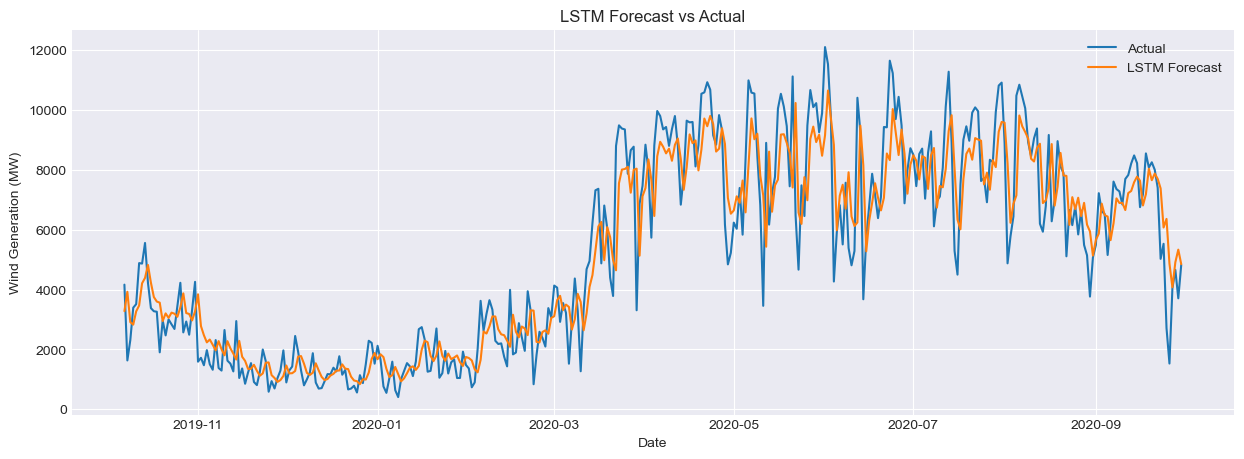

In [51]:
# Plot the predicted wind generation against the actual values
# This helps us evaluate the model's performance and identify patterns the LSTM has learned
# y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(15,5))
plt.plot(test.index[60:], y_test_actual, label="Actual")
plt.plot(test.index[60:], y_pred, label="LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Wind Generation (MW)")
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.show()

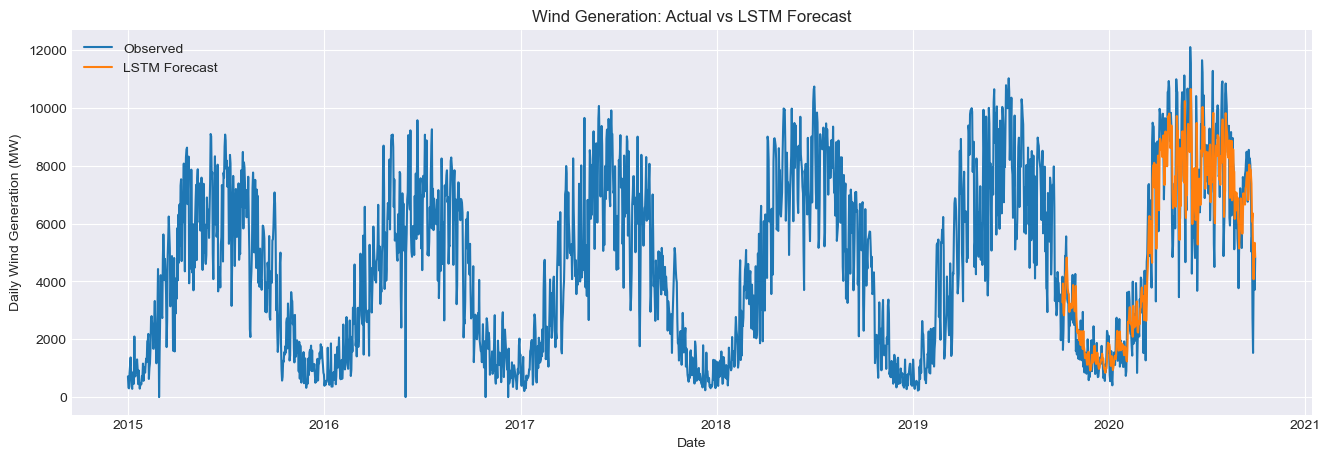

In [52]:
plt.figure(figsize=(16,5))
plt.plot(daily_df.index, daily_df.DE_solar_generation_actual, label='Observed')
plt.plot(test.index[60:], y_pred, label='LSTM Forecast')  
plt.xlabel('Date')
plt.ylabel('Daily Wind Generation (MW)')
plt.title('Wind Generation: Actual vs LSTM Forecast')
plt.legend()
plt.show()

In [53]:
lstm_model.save("lstm_solar_forecast_model.keras")

In [54]:
# from tensorflow.keras.models import load_model
# model = load_model("lstm_wind_forecast_model.keras")

# SARIMA model

In [55]:
print("=" * 70)
print("SARIMA MODEL - QUICK DEMO")
print("=" * 70)
print("Using same train/test split as LSTM for fair comparison")
print(f"Train: {train.index[0].date()} to {train.index[-1].date()} ({len(train)} days)")
print(f"Test:  {test.index[0].date()} to {test.index[-1].date()} ({len(test)} days)")
print("=" * 70)

SARIMA MODEL - QUICK DEMO
Using same train/test split as LSTM for fair comparison
Train: 2015-01-01 to 2019-08-07 (1680 days)
Test:  2019-08-08 to 2020-09-30 (420 days)


## Part 1: Data Preparation and Stationarity Check

### Step 1: Resample the data

In [56]:
train_sarima = daily_df[(daily_df.index >= "2018-01-01") & (daily_df.index < "2020-06-01")]
test_sarima  = daily_df[daily_df.index >= "2020-06-01"]

### Step 2: Stationarity testing 

In [57]:
adf_result = adfuller(train_sarima)
print(f"   ADF Statistic: {adf_result[0]:.3f}")
print(f"   p-value: {adf_result[1]:.3f}")

   ADF Statistic: -1.891
   p-value: 0.336


### Step 3: Seasonality detection (ACF/PACF)


 Checking seasonality with ACF/PACF plots


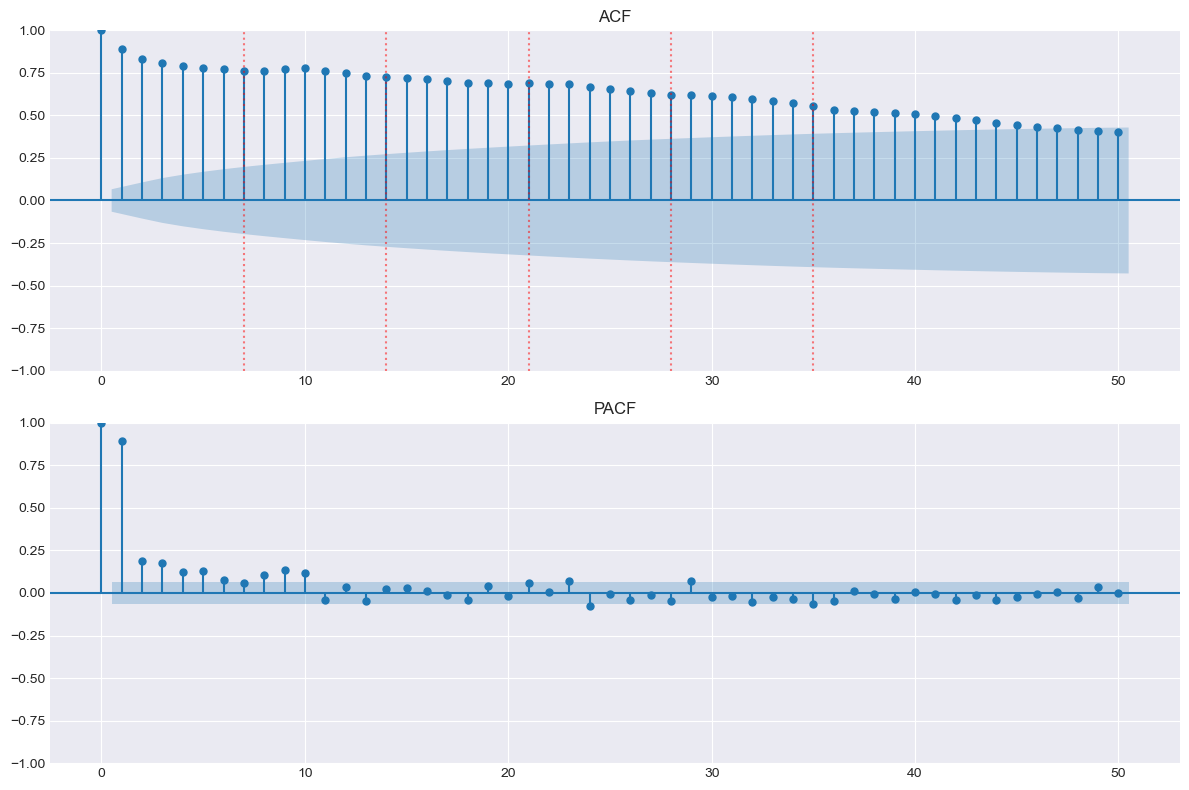

In [58]:
# Check for weekly patterns (ACF) and AR order (PACF)
print("\n Checking seasonality with ACF/PACF plots")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot - look for weekly pattern
plot_acf(train_sarima, lags=50, ax=ax1, title='ACF')
# Mark weekly lags
for week in [7, 14, 21, 28, 35]: ax1.axvline(x=week, color='red', linestyle=':', alpha=0.5)

# PACF plot - decide AR order  
plot_pacf(train_sarima, lags=50, ax=ax2, title='PACF')

plt.tight_layout()
plt.show()

## Part 2: Model identification

In [59]:
y_train = train_sarima.squeeze()
y_test  = test_sarima.squeeze()

In [60]:
smodel = pm.auto_arima(y_train,
                       start_p=0, start_q=0,
                       max_p=3, max_q=3,
                       start_P=0, start_Q=1,
                       d=None, D=1,
                       m=7,  
                       seasonal=True,
                       stepwise=True,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=15620.364, Time=0.62 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=15848.744, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=15354.771, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=15339.904, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=15847.749, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=15634.937, Time=0.09 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=15333.017, Time=0.73 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=15413.382, Time=0.68 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=15326.912, Time=2.44 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=15330.747, Time=1.71 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=15330.072, Time=3.89 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=15317.210, Time=2.44 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=15330.214, Time=1.35 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=15586.822, Time=2.22 sec
 ARIMA(1,0,1)(1,1,2

## Part 3: Candidate model estimation and selection

## Part 4: Final model evaluation

In [61]:
sarima_final = SARIMAX(
    y_train,
    order=(0, 0, 3),              # non-seasonal (p, d, q)
    seasonal_order=(0, 1, 2, 7),  # seasonal (P, D, Q, m) → weekly structure
    enforce_stationarity=False,
    enforce_invertibility=False)

In [62]:
results_final = sarima_final.fit(disp=False)

In [63]:
print(results_final.summary())

                                       SARIMAX Results                                        
Dep. Variable:             DE_solar_generation_actual   No. Observations:                  882
Model:             SARIMAX(0, 0, 3)x(0, 1, [1, 2], 7)   Log Likelihood               -7465.521
Date:                                Wed, 04 Feb 2026   AIC                          14943.043
Time:                                        11:52:22   BIC                          14971.563
Sample:                                    01-01-2018   HQIC                         14953.963
                                         - 05-31-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6227      0.029     21.431      0.000       0.566       0.680
ma.

## Part 5: Model forecasting

In [64]:
forecast = results_final.get_forecast(steps=len(y_test))
y_pred = forecast.predicted_mean
y_pred_ci = forecast.conf_int()

In [65]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 2408.02, MAE: 1935.89


## Part 6: Forecast visualization

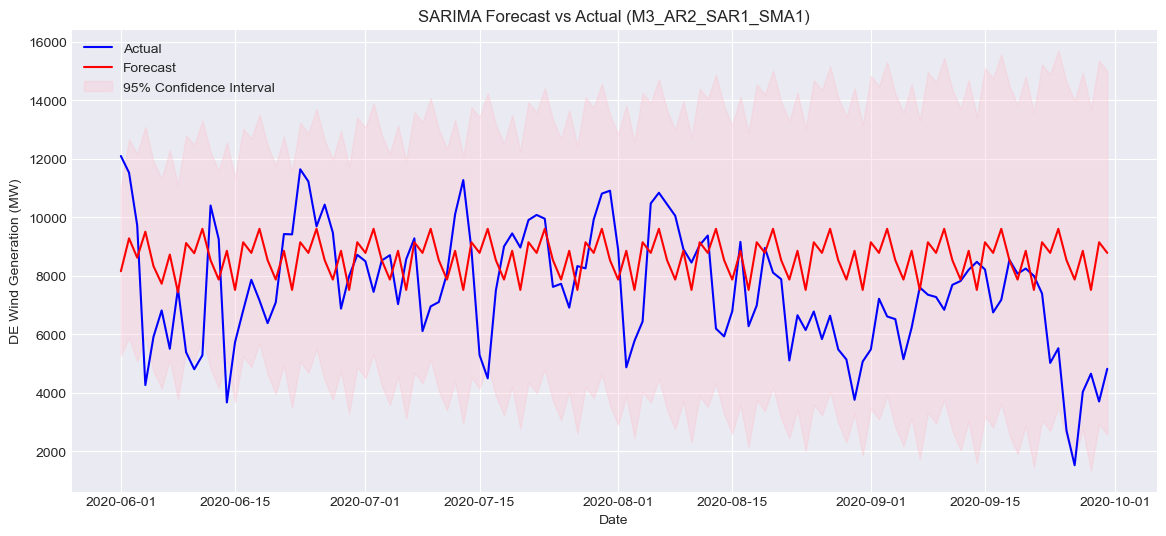

In [66]:
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Forecast', color='red')
plt.fill_between(
    y_test.index,
    y_pred_ci.iloc[:,0],
    y_pred_ci.iloc[:,1],
    color='pink', alpha=0.3,
    label='95% Confidence Interval'
)
plt.title("SARIMA Forecast vs Actual (M3_AR2_SAR1_SMA1)")
plt.xlabel("Date")
plt.ylabel("DE Wind Generation (MW)")
plt.legend()
plt.show()

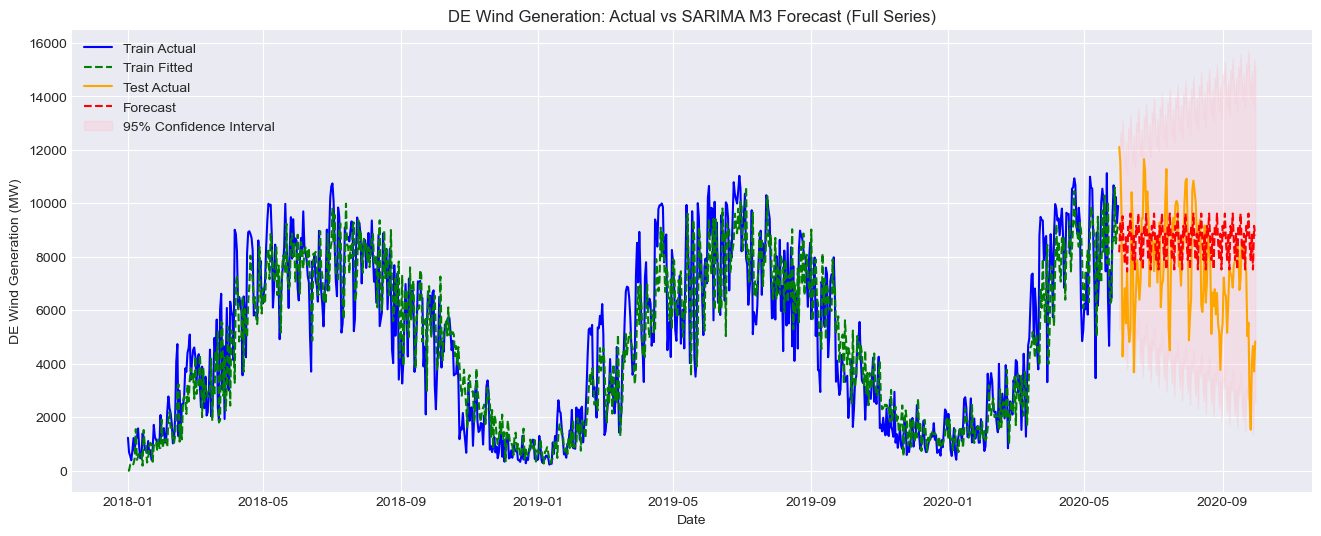

In [67]:
# -------------------------
# 1️. Get in-sample fitted values for the training set
# -------------------------
in_sample_pred = results_final.get_prediction(start=y_train.index[0], end=y_train.index[-1])
in_sample_mean = in_sample_pred.predicted_mean

# Get out-of-sample forecast for the test set
forecast = results_final.get_forecast(steps=len(y_test))
out_sample_pred = forecast.predicted_mean
out_sample_ci = forecast.conf_int()

# -------------------------
# 2. Plot the full series: training + test actuals and predictions
# -------------------------
plt.figure(figsize=(16,6))

# Plot actual values of the training set
plt.plot(y_train.index, y_train, label='Train Actual', color='blue')

# Plot in-sample fitted values (training set)
plt.plot(y_train.index, in_sample_mean, label='Train Fitted', color='green', linestyle='--')

# Plot actual values of the test set
plt.plot(y_test.index, y_test, label='Test Actual', color='orange')

# Plot out-of-sample forecast (test set)
plt.plot(y_test.index, out_sample_pred, label='Forecast', color='red', linestyle='--')

# Add 95% confidence interval for the forecast
plt.fill_between(y_test.index, out_sample_ci.iloc[:,0], out_sample_ci.iloc[:,1], 
                 color='pink', alpha=0.3,label='95% Confidence Interval')

# Add title, axis labels and legend
plt.title("DE Wind Generation: Actual vs SARIMA M3 Forecast (Full Series)")
plt.xlabel("Date")
plt.ylabel("DE Wind Generation (MW)")
plt.legend()
plt.show()

## Part 7: Residual diagnostics

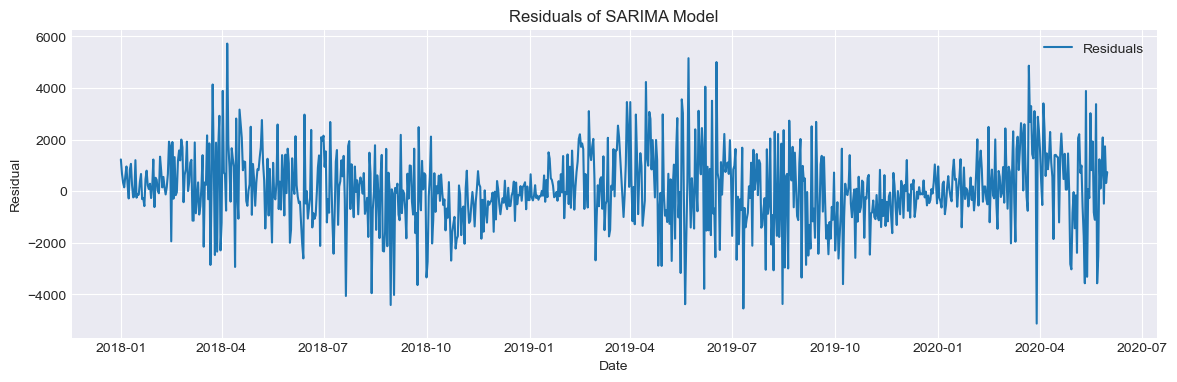

In [68]:
residuals = results_final.resid
plt.figure(figsize=(14,4))
plt.plot(residuals, label='Residuals')
plt.title("Residuals of SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

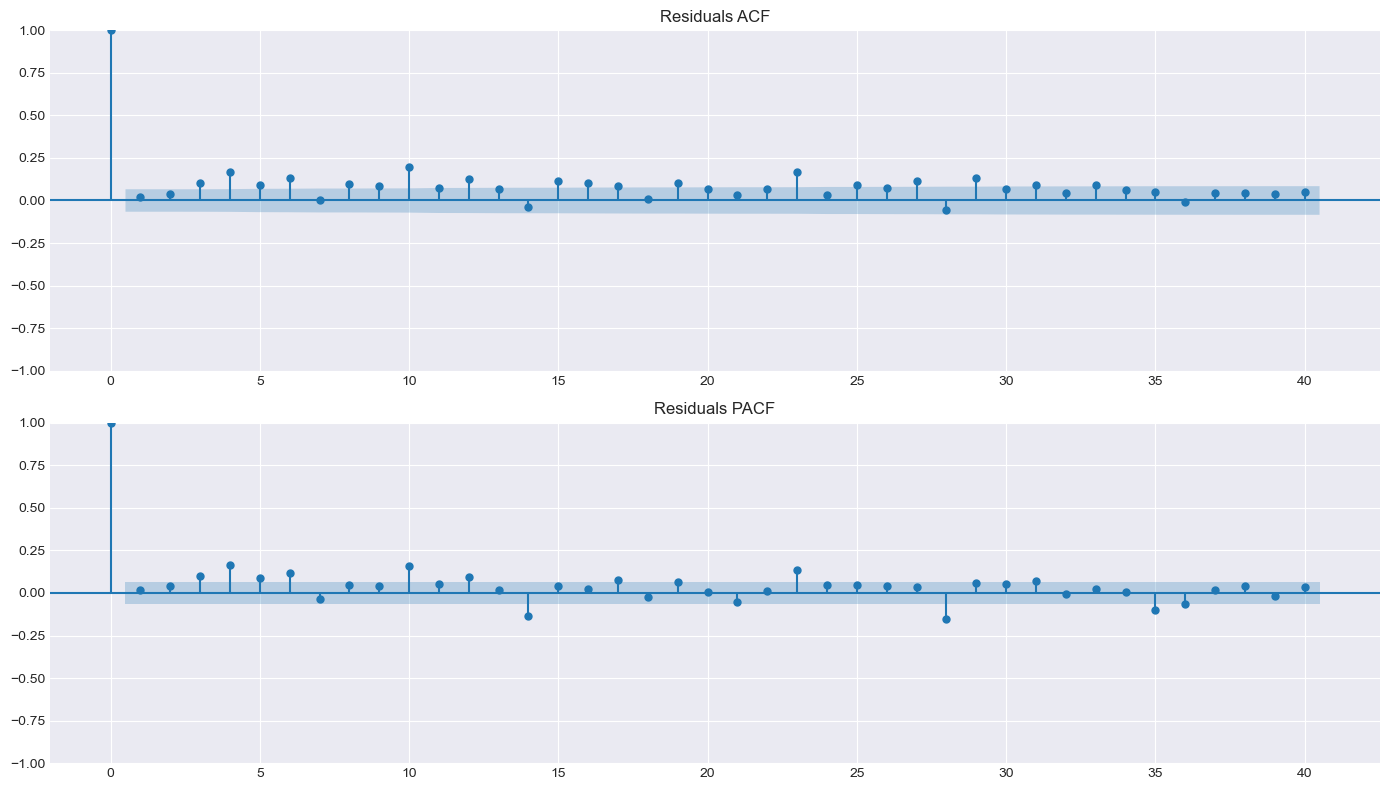

In [69]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,8))
plot_acf(residuals, lags=40, ax=ax1, title='Residuals ACF')
plot_pacf(residuals, lags=40, ax=ax2, title='Residuals PACF')
plt.tight_layout()
plt.show()

In [70]:
# save scaler 
joblib.dump(scaler, "solar_scaler.pkl")

['solar_scaler.pkl']